# Setup + Loading Data

In [1]:
# Importing packages

import json
from pathlib import Path
import pprint
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# import utilities_visualization

In [2]:
# Defining input and output directory

with open("data_2025-09-03 Euler Angles_20250903_203926.json", 'r') as f:
    data_dict = json.load(f)
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [3]:
print("Data Dictionary Structure:")
print(f"{pprint.pformat(data_dict, depth=2)[:210]}\n...")
print(f"{len(list(data_dict['OR'].keys()))} Quantities Included:")
print([data_dict['OR'].keys()])

Data Dictionary Structure:
{'IB': {'Ax': [...],
        'Ay': [...],
        'Az': [...],
        'ax': [...],
        'ay': [...],
        'az': [...],
        'dx': [...],
        'dy': [...],
        'dz': [...],
        'phi': [...],
...
23 Quantities Included:
[dict_keys(['time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'wxy', 'phidot', 'thetadot', 'psidot', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz'])]


In [4]:
def data_to_array(data_dict,
                quantities={
                    'IB':['wx','wy','wz'],
                    'IT':['wx','wy','wz'],
                    'IL':['wx','wy','wz'],
                    'OR':['wxy','psidot'],
                },
                ntime=None):
    """
    Returns an array with shape = (ntime, nquantities)
    Returns an array with shape = (1894,  11)
    """
    data_array = [data_dict[s][q] for s,qset in quantities.items() for q in qset]
    if ntime is not None:
        return np.array(data_array).T[:ntime]
    else:
        return np.array(data_array).T

# PCA

In [5]:
quantities={
    'IB':['wx','wy','wz'],
    'IT':['wx','wy','wz'],
    'IL':['wx','wy','wz'],
    'OR':['wxy','psidot'],
}
# quantities={
#     'IB':['wx','wy','wz'],
#     'IT':['wx','wy','wz'],
#     'IL':['wx','wy','wz'],
#     'OR':['wx','wy','wz'],
# }

In [6]:
# Step 1: Load data
X = data_to_array(data_dict=data_dict, quantities=quantities)
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

X_PCA_hftc = X_pca 

(1894, 11)


In [7]:
explained_variance_ratio

array([0.39183673, 0.2377795 , 0.1373963 , 0.07836422, 0.04293685,
       0.03900221, 0.03041829, 0.01510599, 0.01428139, 0.00858478,
       0.00429373])

In [8]:
def plot_PCA_modes_by_segment(eigenvectors, quantities, n_modes=6):
    sensors = []
    mapping = [[] for _ in quantities]

    for i,(sensor,qset) in enumerate(quantities.items()):
        sensors.append(sensor)
        for q in qset:
            mapping[i].append(q)
    
    n_rows = n_modes
    n_sensors = len(sensors)
    n_cols = n_sensors

    fig,ax = plt.subplots(n_rows, n_cols,
                          gridspec_kw={'width_ratios': [3,3,3,1.6]},
                          figsize=(6.3, n_modes),
                          sharex='col',
                          sharey=True, 
                          constrained_layout=True
                          )

    col_idx = 0
    for j,s in enumerate(sensors): # Each column is a sensor with nq quantities
        nq = len(mapping[j])
        for i in range(n_rows): # Each row is a mode with n_senors sensors
            ax[i,j].plot(eigenvectors[i, col_idx:col_idx+nq], '.', markersize=12)
            ax[i,j].axhline(0, color='gray', linestyle='--', linewidth=0.8)
            ax[i,j].set_ylim(-1, 1)
            ax[i,0].set_ylabel(rf"$v_{{{i+1}}}$")
        col_idx += nq
        ax[-1,j].set_xticks(np.arange(nq))
        ax[-1,j].set_xticklabels(mapping[j],rotation=45)
        ax[-1,j].set_xlabel(s)
        ax[-1,-1].set_xlim(-0.1,1.11)

        plt.savefig('PCA_modes_by_segment.pdf', dpi=400)

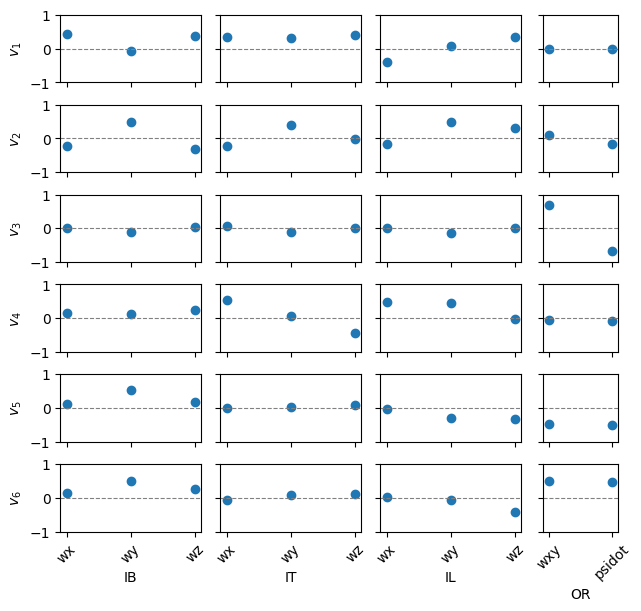

In [9]:
plot_PCA_modes_by_segment(eigenvectors,quantities)